In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-fraud/card_transdata.csv
/kaggle/input/online-payment-fraud-detection/onlinefraud.csv


In [2]:
!pip install kaggle --upgrade

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -O ./spark-3.3.2-bin-hadoop3.tgz  https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar zxvf ./spark-3.3.2-bin-hadoop3.tgz
!pip install findspark
!pip install pyspark

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-02-19 09:33:35--  https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299360284 (285M) [application/x-gzip]
Saving to: ‘./spark-3.3.2-bin-hadoop3.tgz’

./spark-3.3.2-bin-h 100%[===================>] 285.49M   243MB/s    in 1.2s    

2023-02-19 09:33:36 (243 MB/s) - ‘./spark-3.3.2-bin-hadoop3.tgz’ saved [299360284/299360284]

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
spark-3.3.2-bin-hadoop3/
spark-3.3.2-bin-hadoop3/LICENSE
spark-3.3.2-bin-hadoop3/NOTICE
spark-3.3.2-bin-hadoop3/R/
spark-3.3.2-bin-hadoo

In [4]:
import findspark
import random
import pyspark
from pyspark.sql import functions as f

In [5]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/kaggle/working/spark-3.3.2-bin-hadoop3"
findspark.init()

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('treatmeant').getOrCreate()

bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by bash)
bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by bash)
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/19 09:34:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
training_columns = ['step','type','amount','nameOrig','oldbalanceOrg','newbalanceOrig','nameDest','oldbalanceDest','newbalanceDest']

In [8]:
# Use Spark to read the training csv file.
bdp_train = spark.read.csv("/kaggle/input/online-payment-fraud-detection", inferSchema=True, header=True)\
                 .fillna(0, subset=training_columns)

In [9]:
# Show Columns
bdp_train.show()

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT| 11668.14|C2048537720|      41554.0|      29885.86|M123070170

In [10]:
bdp_train.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = false)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = false)
 |-- newbalanceOrig: double (nullable = false)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = false)
 |-- newbalanceDest: double (nullable = false)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



In [11]:
# EDA
import pyspark.sql.functions
bdp_train.describe().show()

+-------+------------------+--------+------------------+-----------+-----------------+-----------------+-----------+------------------+------------------+--------------------+--------------------+
|summary|              step|    type|            amount|   nameOrig|    oldbalanceOrg|   newbalanceOrig|   nameDest|    oldbalanceDest|    newbalanceDest|             isFraud|      isFlaggedFraud|
+-------+------------------+--------+------------------+-----------+-----------------+-----------------+-----------+------------------+------------------+--------------------+--------------------+
|  count|           6362620| 6362620|           6362620|    6362620|          6362620|          6362620|    6362620|           6362620|           6362620|             6362620|             6362620|
|   mean|243.39724563151657|    null|179861.90354913412|       null|833883.1040744719|855113.6685785714|       null|1100701.6665196654|1224996.3982019408|0.001290820448180152| 2.51468734577894E-6|
| stddev|142.33

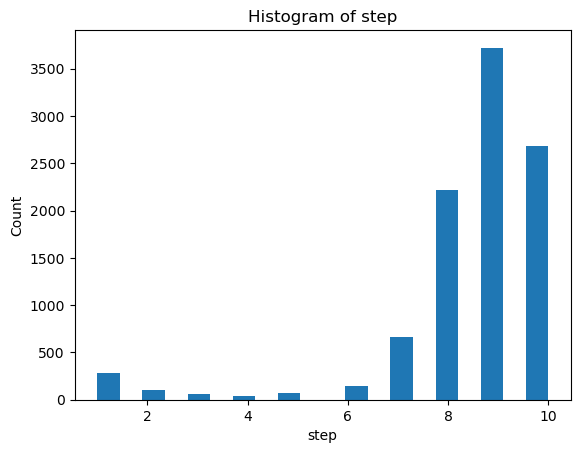

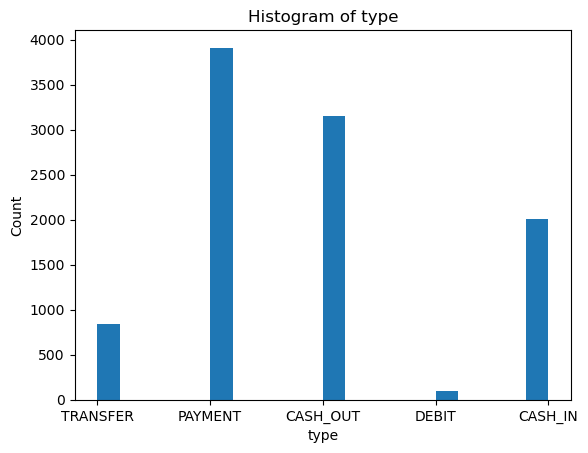

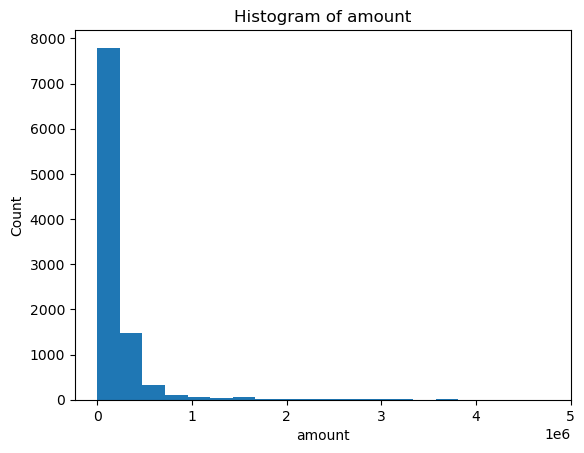

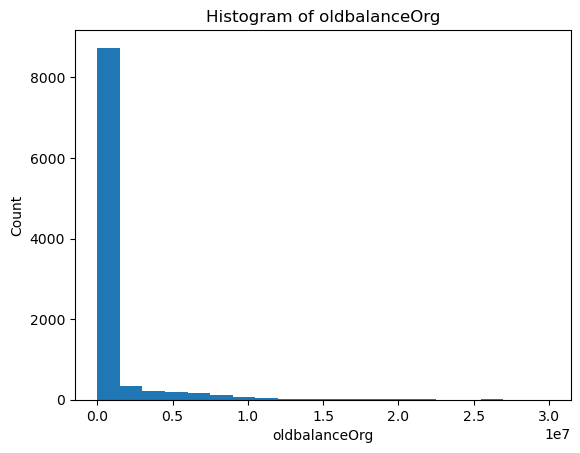

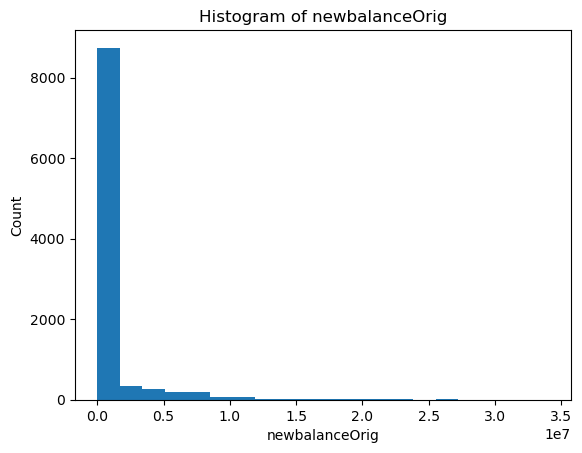

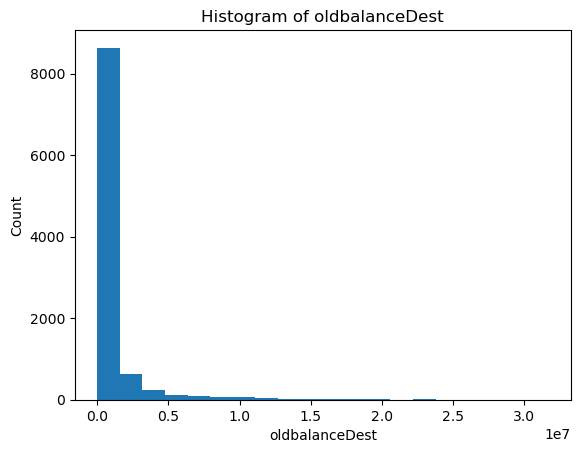

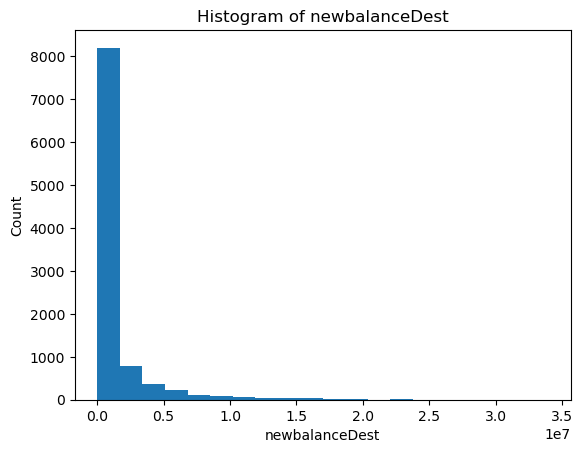

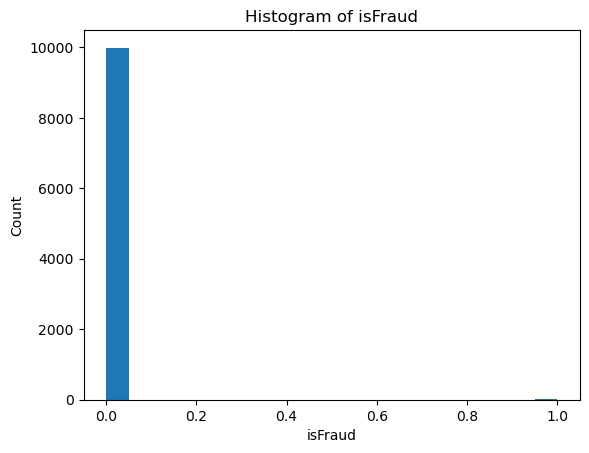

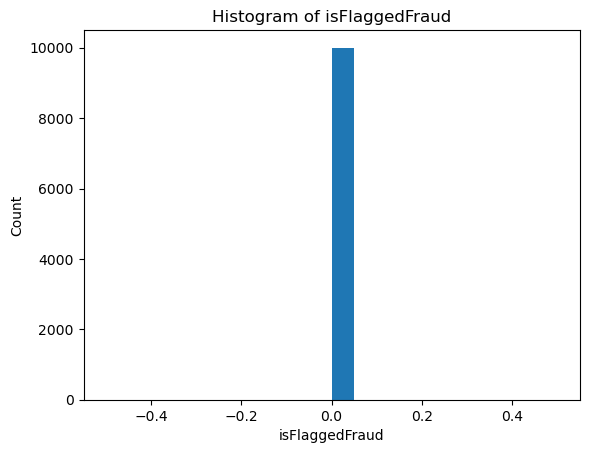

In [12]:
# Histograms of sampled each column
import matplotlib.pyplot as plt
for column in ['step',
 'type',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']:
    # Select a random sample of 1000 rows from the column and convert it to a Pandas DataFrame for plotting
    column_data = bdp_train.select(column).sample(False, 0.1).limit(10000).toPandas()

    # Plot the histogram
    plt.hist(column_data[column], bins=20)
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()

In [13]:
from pyspark.sql.functions import count
print('table of isFraud column')
bdp_train.groupBy("isFraud").count().show()
print('table of type column')
bdp_train.groupBy("type").count().show()

table of isFraud column


+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   8213|
|      0|6354407|
+-------+-------+

table of type column


+--------+-------+
|    type|  count|
+--------+-------+
|TRANSFER| 532909|
| CASH_IN|1399284|
|CASH_OUT|2237500|
| PAYMENT|2151495|
|   DEBIT|  41432|
+--------+-------+



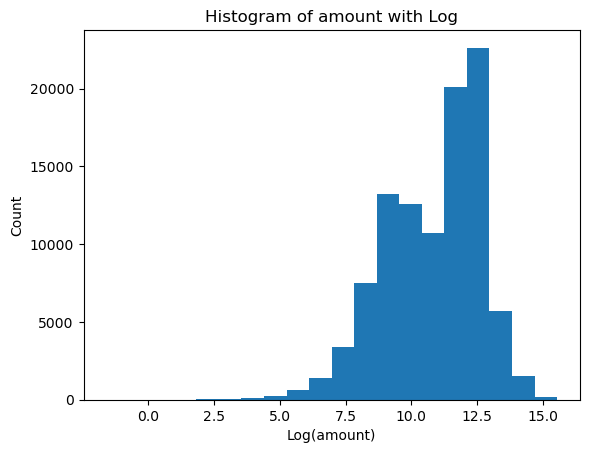

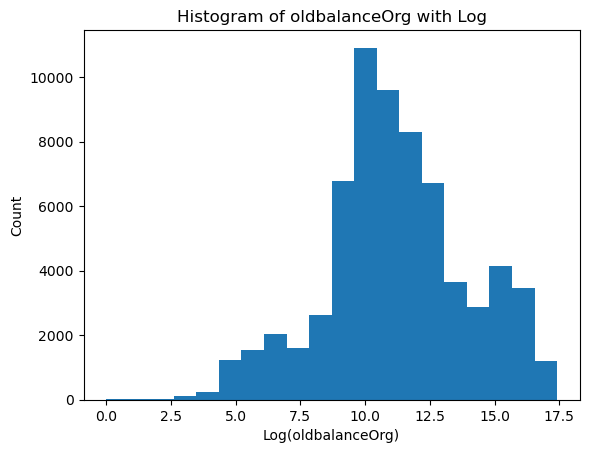

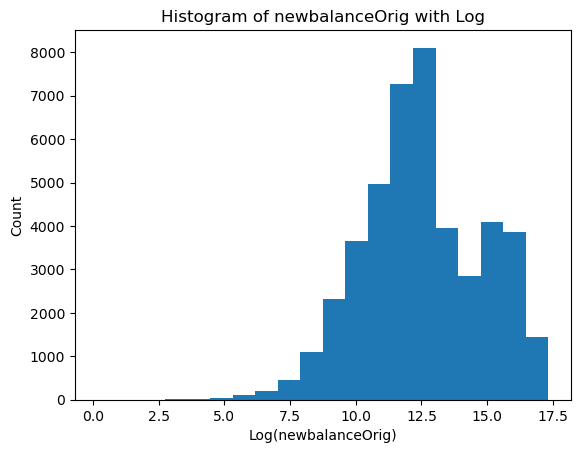

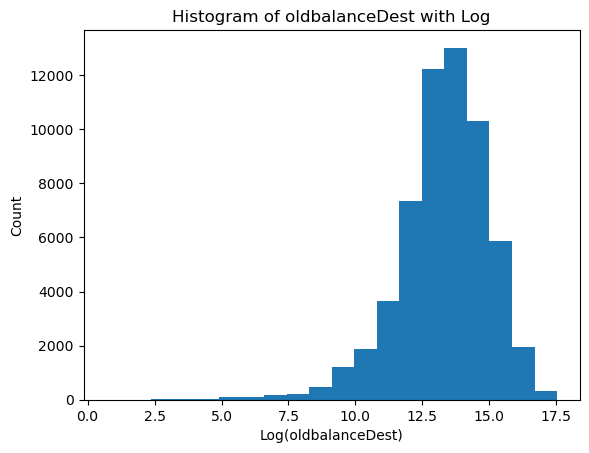

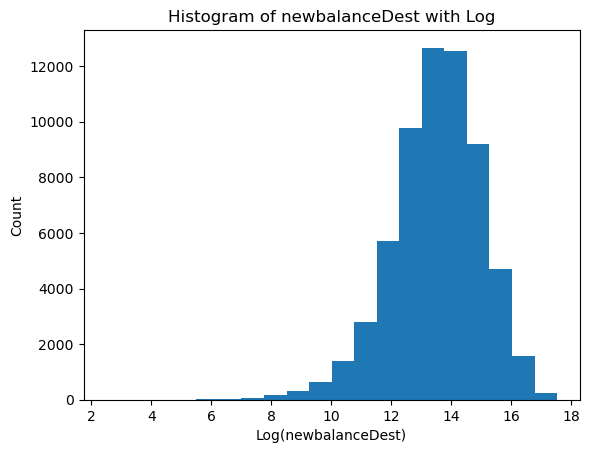

In [14]:
from pyspark.sql.functions import col, log
import matplotlib.pyplot as plt

for column in ['amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest']:
    # Select a random sample of 1000 rows from the column and convert it to a Pandas DataFrame for plotting
    column_data = bdp_train.select(log(col(column))).sample(False, 0.1).limit(100000)
    # Plot the histogram
    column_data_pandas = column_data.toPandas()
    plt.hist(column_data_pandas[f"ln({column})"], bins=20)
    plt.title(f"Histogram of {column} with Log")
    plt.xlabel(f"Log({column})")
    plt.ylabel("Count")
    plt.show()

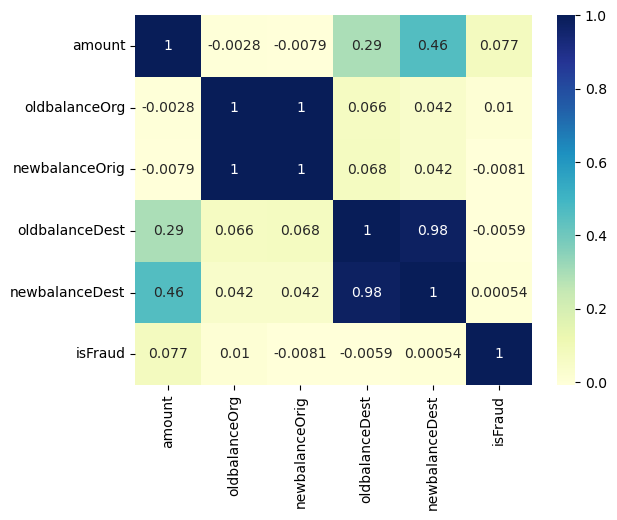

In [15]:
from pyspark.sql.functions import corr

import seaborn as sns

import matplotlib.pyplot as plt
 

# Select the columns to include in the heatmap

columns = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud']


# Calculate the correlation matrix

corr_matrix = bdp_train.select(columns).toPandas().corr()

 

# Create a heatmap using the seaborn library

sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True)

 

# Show the plot

plt.show()

In [16]:
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window

bdp_index = bdp_train.withColumn('index', row_number().over(Window.orderBy(monotonically_increasing_id())))

In [17]:
train_feature = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

In [18]:
from pyspark.ml.feature import VectorAssembler

In [19]:
assembler = VectorAssembler(inputCols=train_feature, outputCol='features', handleInvalid="keep")
train_data_df = assembler.transform(bdp_index).select('index', 'features', 'isFraud')

In [20]:
train_data_df = train_data_df.withColumn("isFraud",train_data_df.isFraud.cast('double'))

In [21]:
train_data_df.show(5)

23/02/19 09:39:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:39:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:39:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:40:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:40:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----+--------------------+-------+
|index|            features|isFraud|
+-----+--------------------+-------+
|    1|[9839.64,170136.0...|    0.0|
|    2|[1864.28,21249.0,...|    0.0|
|    3|(5,[0,1],[181.0,1...|    1.0|
|    4|[181.0,181.0,0.0,...|    1.0|
|    5|[11668.14,41554.0...|    0.0|
+-----+--------------------+-------+
only showing top 5 rows



In [22]:
train_data, val_data = train_data_df.randomSplit([0.7, 0.3])

In [23]:
train_data.distinct().show(20)

23/02/19 09:40:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:40:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:40:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:40:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----+--------------------+-------+
|index|            features|isFraud|
+-----+--------------------+-------+
|    1|[9839.64,170136.0...|    0.0|
|    2|[1864.28,21249.0,...|    0.0|
|    3|(5,[0,1],[181.0,1...|    1.0|
|    4|[181.0,181.0,0.0,...|    1.0|
|    6|[7817.71,53860.0,...|    0.0|
|    8|[7861.64,176087.2...|    0.0|
|    9|(5,[0,1],[4024.36...|    0.0|
|   10|[5337.77,41720.0,...|    0.0|
|   11|[9644.94,4465.0,0...|    0.0|
|   13|[2560.74,5070.0,2...|    0.0|
|   15|[4098.78,503264.0...|    0.0|
|   17|(5,[0,1],[1563.82...|    0.0|
|   18|[1157.86,21156.0,...|    0.0|
|   19|[671.64,15123.0,1...|    0.0|
|   20|[215310.3,705.0,0...|    0.0|
|   22|[9302.79,11299.0,...|    0.0|
|   25|[311685.89,10835....|    0.0|
|   26|(5,[0,1],[6061.13...|    0.0|
|   27|[9478.39,116494.0...|    0.0|
|   28|[8009.09,10968.0,...|    0.0|
+-----+--------------------+-------+
only showing top 20 rows



**Random Forest model on dataset: Online Payment Fraud Detection**

In [24]:
# Import model
from pyspark.ml.classification import RandomForestClassifier

In [25]:
from pyspark.ml import Pipeline

In [26]:
rfc = RandomForestClassifier(labelCol='isFraud', featuresCol='features', numTrees=5, maxDepth=4)

In [27]:
rfc_model = rfc.fit(train_data)

23/02/19 09:41:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:41:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:41:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:41:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:41:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:41:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:41:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:41:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:41:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:41:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:41:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:41:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:41:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:41:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:43:30 WARN MemoryStore: Not enough space to cache rdd_155_0 in memory! (computed 213.3 MiB so far)
23/02/19 09:43:30 WARN BlockManager: Persisting block rdd_155_0 to disk instead.
23/02/19 09:43:44 WARN MemoryStore: Not enough space to cache rdd_155_0 in memory! (computed 332.8 MiB so far)


23/02/19 09:43:52 WARN MemoryStore: Not enough space to cache rdd_155_0 in memory! (computed 332.8 MiB so far)


23/02/19 09:44:01 WARN MemoryStore: Not enough space to cache rdd_155_0 in memory! (computed 332.8 MiB so far)


23/02/19 09:44:10 WARN MemoryStore: Not enough space to cache rdd_155_0 in memory! (computed 332.8 MiB so far)


23/02/19 09:44:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:44:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:44:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:44:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:44:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:44:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:44:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:44:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:44:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:44:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [28]:
# check the important features
importances=rfc_model.featureImportances

In [29]:
importances_dict = dict(zip(range(len(importances)), importances.toArray()))
for i in sorted(importances_dict, key=importances_dict.get, reverse=True):
    print("Feature " + str(i) + ": " + str(importances_dict[i]))

Feature 1: 0.4222706446995002
Feature 4: 0.3590724531000493
Feature 2: 0.09981058355672541
Feature 3: 0.0728182534565293
Feature 0: 0.04602806518719588


In [30]:
rfc_preds = rfc_model.transform(val_data)

In [31]:
rfc_preds.printSchema()

root
 |-- index: integer (nullable = false)
 |-- features: vector (nullable = true)
 |-- isFraud: double (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [32]:
rfc_preds.show(5)

23/02/19 09:44:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:44:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:44:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:44:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:44:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----+--------------------+-------+--------------------+--------------------+----------+
|index|            features|isFraud|       rawPrediction|         probability|prediction|
+-----+--------------------+-------+--------------------+--------------------+----------+
|    5|[11668.14,41554.0...|    0.0|[4.99763733022556...|[0.99952746604511...|       0.0|
|    7|[7107.77,183195.0...|    0.0|[4.99649835911834...|[0.99929967182366...|       0.0|
|   12|[3099.97,20771.0,...|    0.0|[4.99763733022556...|[0.99952746604511...|       0.0|
|   14|(5,[0,1],[11633.7...|    0.0|[4.99651048295642...|[0.99930209659128...|       0.0|
|   16|[229133.94,15325....|    0.0|[4.99651048295642...|[0.99930209659128...|       0.0|
+-----+--------------------+-------+--------------------+--------------------+----------+
only showing top 5 rows



In [33]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [34]:
binary_eval = BinaryClassificationEvaluator(labelCol='isFraud')

In [35]:
rfc_preds.show(10)

23/02/19 09:45:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:45:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:45:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:45:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:45:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----+--------------------+-------+--------------------+--------------------+----------+
|index|            features|isFraud|       rawPrediction|         probability|prediction|
+-----+--------------------+-------+--------------------+--------------------+----------+
|    5|[11668.14,41554.0...|    0.0|[4.99763733022556...|[0.99952746604511...|       0.0|
|    7|[7107.77,183195.0...|    0.0|[4.99649835911834...|[0.99929967182366...|       0.0|
|   12|[3099.97,20771.0,...|    0.0|[4.99763733022556...|[0.99952746604511...|       0.0|
|   14|(5,[0,1],[11633.7...|    0.0|[4.99651048295642...|[0.99930209659128...|       0.0|
|   16|[229133.94,15325....|    0.0|[4.99651048295642...|[0.99930209659128...|       0.0|
|   21|[1373.43,13854.0,...|    0.0|[4.99763733022556...|[0.99952746604511...|       0.0|
|   23|[1065.41,1817.0,7...|    0.0|[4.99763733022556...|[0.99952746604511...|       0.0|
|   24|[3876.41,67852.0,...|    0.0|[4.99763733022556...|[0.99952746604511...|       0.0|
|   31|   

In [36]:
print('RFC prediction AUC:', binary_eval.evaluate(rfc_preds))

23/02/19 09:45:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:45:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:45:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:45:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:45:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


RFC prediction AUC: 0.8789766708519056


In [37]:
# test data
test_data = val_data

In [38]:
rfc_test_preds = rfc_model.transform(test_data)

In [39]:
rfc_test_preds.show()

23/02/19 09:46:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:46:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:46:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:46:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:46:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----+--------------------+-------+--------------------+--------------------+----------+
|index|            features|isFraud|       rawPrediction|         probability|prediction|
+-----+--------------------+-------+--------------------+--------------------+----------+
|    5|[11668.14,41554.0...|    0.0|[4.99763733022556...|[0.99952746604511...|       0.0|
|    7|[7107.77,183195.0...|    0.0|[4.99649835911834...|[0.99929967182366...|       0.0|
|   12|[3099.97,20771.0,...|    0.0|[4.99763733022556...|[0.99952746604511...|       0.0|
|   14|(5,[0,1],[11633.7...|    0.0|[4.99651048295642...|[0.99930209659128...|       0.0|
|   16|[229133.94,15325....|    0.0|[4.99651048295642...|[0.99930209659128...|       0.0|
|   21|[1373.43,13854.0,...|    0.0|[4.99763733022556...|[0.99952746604511...|       0.0|
|   23|[1065.41,1817.0,7...|    0.0|[4.99763733022556...|[0.99952746604511...|       0.0|
|   24|[3876.41,67852.0,...|    0.0|[4.99763733022556...|[0.99952746604511...|       0.0|
|   31|   

In [40]:
rfc_test_preds.head()

23/02/19 09:46:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:46:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:46:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:46:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:46:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Row(index=5, features=DenseVector([11668.14, 41554.0, 29885.86, 0.0, 0.0]), isFraud=0.0, rawPrediction=DenseVector([4.9976, 0.0024]), probability=DenseVector([0.9995, 0.0005]), prediction=0.0)

In [41]:
from pyspark.ml.functions import vector_to_array
rfc_test_preds.withColumn('ProbToYes', vector_to_array(f.col('probability')).getItem(1)).show()

23/02/19 09:47:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:47:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:47:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:47:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:47:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----+--------------------+-------+--------------------+--------------------+----------+--------------------+
|index|            features|isFraud|       rawPrediction|         probability|prediction|           ProbToYes|
+-----+--------------------+-------+--------------------+--------------------+----------+--------------------+
|    5|[11668.14,41554.0...|    0.0|[4.99763733022556...|[0.99952746604511...|       0.0|4.725339548876496...|
|    7|[7107.77,183195.0...|    0.0|[4.99649835911834...|[0.99929967182366...|       0.0|7.003281763302962E-4|
|   12|[3099.97,20771.0,...|    0.0|[4.99763733022556...|[0.99952746604511...|       0.0|4.725339548876496...|
|   14|(5,[0,1],[11633.7...|    0.0|[4.99651048295642...|[0.99930209659128...|       0.0|6.979034087152317E-4|
|   16|[229133.94,15325....|    0.0|[4.99651048295642...|[0.99930209659128...|       0.0|6.979034087152317E-4|
|   21|[1373.43,13854.0,...|    0.0|[4.99763733022556...|[0.99952746604511...|       0.0|4.725339548876496...|
|

In [42]:
rfc_test_preds = rfc_model.transform(test_data)\
                          .withColumn('ProbToYes', vector_to_array(f.col('probability')).getItem(1))\
                          .select('index', 'ProbToYes')

In [43]:
rfc_test_preds.printSchema()

root
 |-- index: integer (nullable = false)
 |-- ProbToYes: double (nullable = true)



In [44]:
rfc_test_preds.show(5)

23/02/19 09:47:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:47:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:47:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:47:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:47:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----+--------------------+
|index|           ProbToYes|
+-----+--------------------+
|    5|4.725339548876496...|
|    7|7.003281763302962E-4|
|   12|4.725339548876496...|
|   14|6.979034087152317E-4|
|   16|6.979034087152317E-4|
+-----+--------------------+
only showing top 5 rows



In [45]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# create a DataFrame with predictions and true labels
predictions = rfc_model.transform(test_data)
predictions_and_labels = predictions.select("prediction", "isFraud")

# create an evaluator for binary classification
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="isFraud")

# calculate precision, recall, and F1 score
precision = evaluator.evaluate(predictions_and_labels, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions_and_labels, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions_and_labels, {evaluator.metricName: "f1"})

23/02/19 09:48:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:48:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:48:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:48:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:48:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:48:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:48:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:48:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:48:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:48:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:49:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:49:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:49:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:49:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:49:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [46]:
# Precision of random forest model on the main dataset "online fraud detection"
print("Precision of random forest model on the main dataset - online fraud detection",precision)

# Recall of random forest model on the main dataset "online fraud detection"
print("Recall of random forest model on the main dataset - online fraud detection",recall)

# F1-score of random forest model on the main dataset "online fraud detection"
print("F1-score of random forest model on the main dataset - online fraud detection",f1_score)

Precision of random forest model on the main dataset - online fraud detection 0.9990536394858035
Recall of random forest model on the main dataset - online fraud detection 0.9991191478384517
F1-score of random forest model on the main dataset - online fraud detection 0.9989195111618169


**Random Forest model on dataset: Credit Card Fraud**

In [47]:
training_columns2 = ['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price','repeat_retailer','used_chip','used_pin_number','online_order']

In [48]:
# Use Spark to read the training csv file.
bdp_train2 = spark.read.csv("/kaggle/input/credit-card-fraud", inferSchema=True, header=True)\
                 .fillna(0, subset=training_columns2)

In [49]:
# Show Columns
bdp_train2.show()

+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+
|distance_from_home|distance_from_last_transaction|ratio_to_median_purchase_price|repeat_retailer|used_chip|used_pin_number|online_order|fraud|
+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+
| 57.87785658389723|            0.3111400080477545|            1.9459399775518593|            1.0|      1.0|            0.0|         0.0|  0.0|
|10.829942699255545|           0.17559150228166587|            1.2942188106198573|            1.0|      0.0|            0.0|         0.0|  0.0|
| 5.091079490616996|            0.8051525945853258|           0.42771456119427587|            1.0|      0.0|            0.0|         1.0|  0.0|
|2.2475643282963613|              5.60004354707232|           0.36266257805709584|            1.0|      1.0|            0.0|         1.0

In [50]:
bdp_train2.printSchema()

root
 |-- distance_from_home: double (nullable = false)
 |-- distance_from_last_transaction: double (nullable = false)
 |-- ratio_to_median_purchase_price: double (nullable = false)
 |-- repeat_retailer: double (nullable = false)
 |-- used_chip: double (nullable = false)
 |-- used_pin_number: double (nullable = false)
 |-- online_order: double (nullable = false)
 |-- fraud: double (nullable = true)



In [51]:
# EDA - second dataset "Credit card fraud"
import pyspark.sql.functions
bdp_train2.describe().show()

+-------+--------------------+------------------------------+------------------------------+-------------------+-------------------+------------------+-------------------+-------------------+
|summary|  distance_from_home|distance_from_last_transaction|ratio_to_median_purchase_price|    repeat_retailer|          used_chip|   used_pin_number|       online_order|              fraud|
+-------+--------------------+------------------------------+------------------------------+-------------------+-------------------+------------------+-------------------+-------------------+
|  count|             1000000|                       1000000|                       1000000|            1000000|            1000000|           1000000|            1000000|            1000000|
|   mean|  26.628792192571257|            5.0365193978615235|             1.824181978404513|           0.881536|           0.350399|          0.100608|           0.650552|           0.087403|
| stddev|   65.39078439904499|          

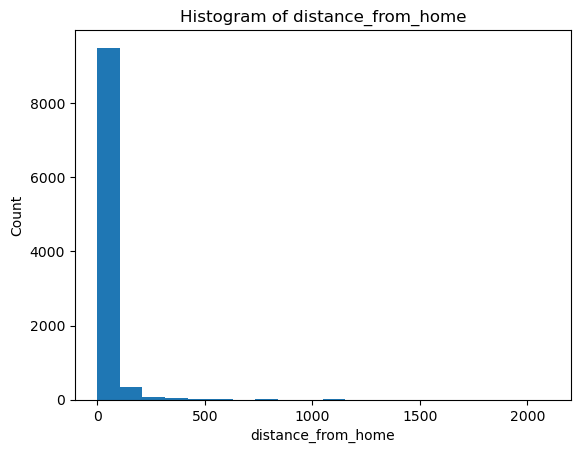

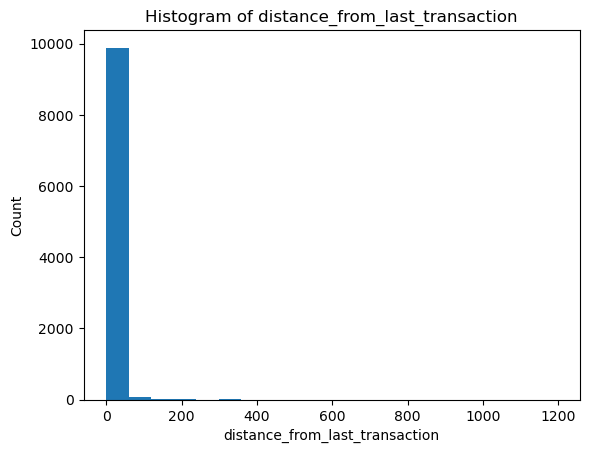

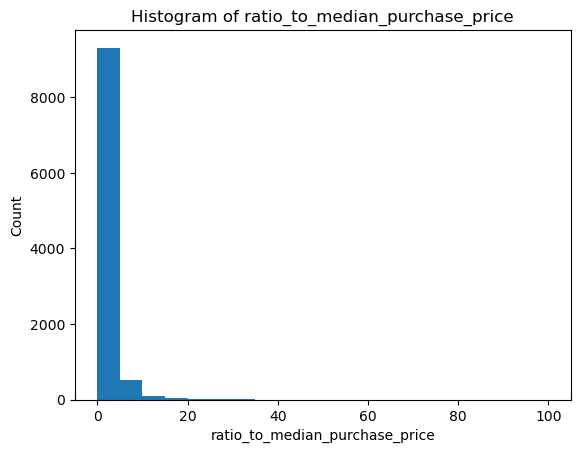

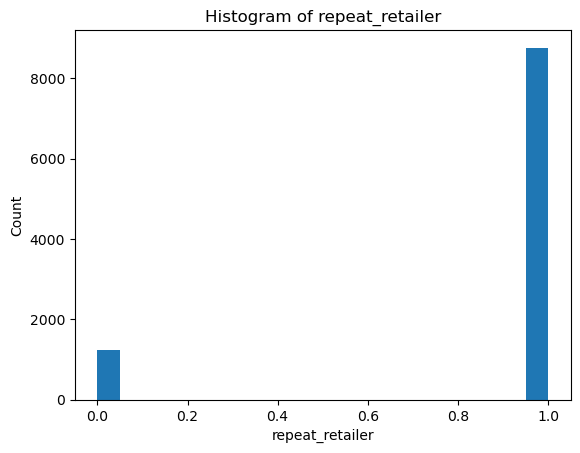

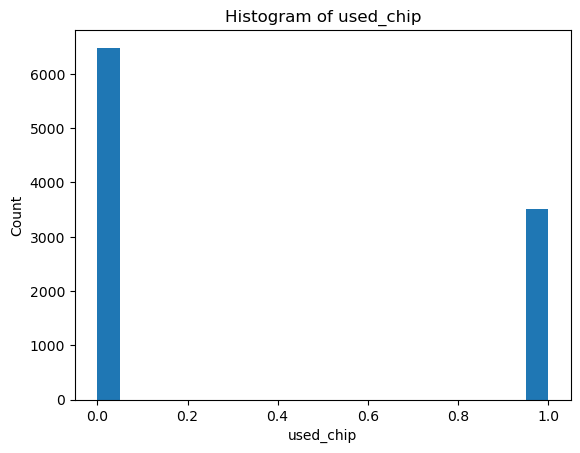

In [52]:
#Histograms of sampled each column
import matplotlib.pyplot as plt
for column in ['distance_from_home',
 'distance_from_last_transaction',
 'ratio_to_median_purchase_price',
 'repeat_retailer',
 'used_chip']:
    # Select a random sample of 1000 rows from the column and convert it to a Pandas DataFrame for plotting
    column_data = bdp_train2.select(column).sample(False, 0.1).limit(10000).toPandas()

    # Plot the histogram
    plt.hist(column_data[column], bins=20)
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()

In [53]:
from pyspark.sql.functions import count
print('table of fraud column')
bdp_train2.groupBy("fraud").count().show()
print('table of used chip column')
bdp_train2.groupBy("used_chip").count().show()
print('table of repeat retailer column')
bdp_train2.groupBy("repeat_retailer").count().show()

table of fraud column


+-----+------+
|fraud| count|
+-----+------+
|  0.0|912597|
|  1.0| 87403|
+-----+------+

table of used chip column


+---------+------+
|used_chip| count|
+---------+------+
|      0.0|649601|
|      1.0|350399|
+---------+------+

table of repeat retailer column


+---------------+------+
|repeat_retailer| count|
+---------------+------+
|            0.0|118464|
|            1.0|881536|
+---------------+------+



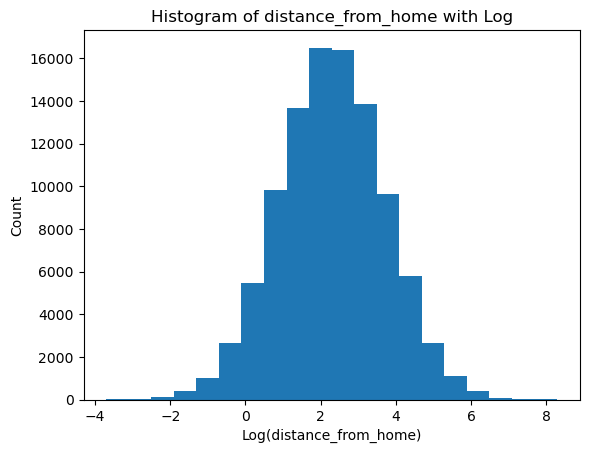

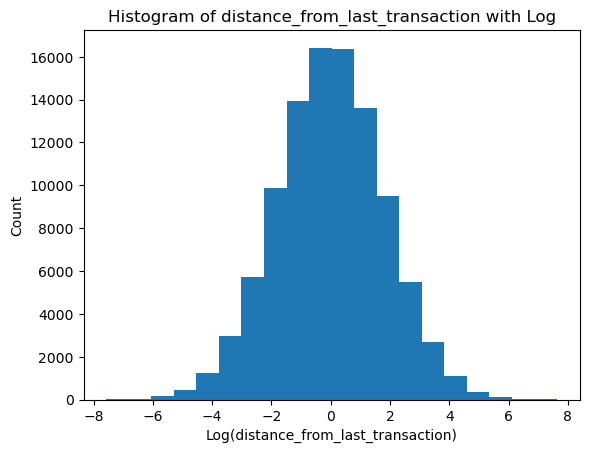

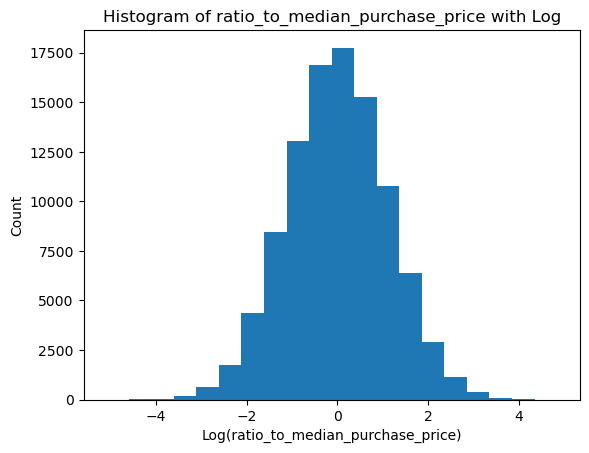

In [54]:


from pyspark.sql.functions import col, log
import matplotlib.pyplot as plt

for column in ['distance_from_home',
 'distance_from_last_transaction',
 'ratio_to_median_purchase_price']:
    # Select a random sample of 1000 rows from the column and convert it to a Pandas DataFrame for plotting
    column_data = bdp_train2.select(log(col(column))).sample(False, 0.1).limit(100000)
    # Plot the histogram
    column_data_pandas = column_data.toPandas()
    plt.hist(column_data_pandas[f"ln({column})"], bins=20)
    plt.title(f"Histogram of {column} with Log")
    plt.xlabel(f"Log({column})")
    plt.ylabel("Count")
    plt.show()

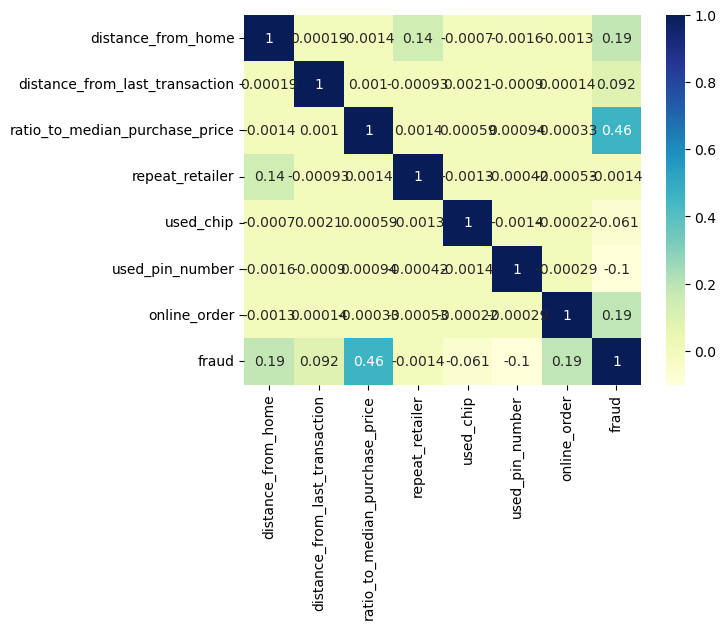

In [55]:
from pyspark.sql.functions import corr

import seaborn as sns

import matplotlib.pyplot as plt
 

# Select the columns to include in the heatmap

columns2 = ['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price','repeat_retailer','used_chip','used_pin_number','online_order','fraud']


# Calculate the correlation matrix

corr_matrix2 = bdp_train2.select(columns2).toPandas().corr()

 

# Create a heatmap using the seaborn library

sns.heatmap(corr_matrix2, cmap="YlGnBu", annot=True)

 

# Show the plot

plt.show()

In [56]:
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window

bdp_index2 = bdp_train2.withColumn('index', row_number().over(Window.orderBy(monotonically_increasing_id())))

In [57]:
train_feature2 = ['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price','repeat_retailer','used_chip','used_pin_number','online_order']

In [58]:
from pyspark.ml.feature import VectorAssembler

In [59]:
assembler2 = VectorAssembler(inputCols=train_feature2, outputCol='features', handleInvalid="keep")
train_data_df2 = assembler2.transform(bdp_index2).select('index', 'features', 'fraud')

In [60]:
train_data_df2 = train_data_df2.withColumn("fraud",train_data_df2.fraud.cast('double'))

In [61]:
train_data_df2.show(5)

23/02/19 09:50:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:50:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----+--------------------+-----+
|index|            features|fraud|
+-----+--------------------+-----+
|    1|[57.8778565838972...|  0.0|
|    2|[10.8299426992555...|  0.0|
|    3|[5.09107949061699...|  0.0|
|    4|[2.24756432829636...|  0.0|
|    5|[44.1909360026183...|  0.0|
+-----+--------------------+-----+
only showing top 5 rows



In [62]:
train_data2, val_data2 = train_data_df2.randomSplit([0.7, 0.3])

In [63]:
train_data2.distinct().show(20)

23/02/19 09:50:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:50:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----+--------------------+-----+
|index|            features|fraud|
+-----+--------------------+-----+
|    1|[57.8778565838972...|  0.0|
|    2|[10.8299426992555...|  0.0|
|    3|[5.09107949061699...|  0.0|
|    4|[2.24756432829636...|  0.0|
|    5|[44.1909360026183...|  0.0|
|    6|[5.58640767418640...|  0.0|
|    7|[3.72401912471481...|  0.0|
|    8|[4.84824657228056...|  0.0|
|    9|(7,[0,1,2],[0.876...|  0.0|
|   12|[13.5923675679096...|  0.0|
|   14|[2.13195566599056...|  1.0|
|   16|[179.665147685707...|  0.0|
|   17|[114.519789391612...|  0.0|
|   18|[3.58964859762134...|  0.0|
|   19|[11.0851524840576...|  0.0|
|   20|[6.19467076632605...|  0.0|
|   21|[78.6232422859794...|  0.0|
|   22|[3.92221196016581...|  0.0|
|   27|[5.48298232194300...|  0.0|
|   28|[53.4655583429363...|  0.0|
+-----+--------------------+-----+
only showing top 20 rows



In [64]:
# Import model
from pyspark.ml.classification import RandomForestClassifier

In [65]:
from pyspark.ml import Pipeline

In [66]:
rfc2 = RandomForestClassifier(labelCol='fraud', featuresCol='features', numTrees=5, maxDepth=2)

In [67]:
rfc_model2 = rfc2.fit(train_data2)

23/02/19 09:50:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:50:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:50:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:50:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:50:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:50:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:50:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:50:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [68]:
rfc_preds2 = rfc_model2.transform(val_data2)

In [69]:
rfc_preds2.printSchema()

root
 |-- index: integer (nullable = false)
 |-- features: vector (nullable = true)
 |-- fraud: double (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [70]:
rfc_preds2.show(5)

23/02/19 09:50:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:50:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:50:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----+--------------------+-----+--------------------+--------------------+----------+
|index|            features|fraud|       rawPrediction|         probability|prediction|
+-----+--------------------+-----+--------------------+--------------------+----------+
|   10|[8.83904670372637...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|
|   11|[14.2635297350690...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|
|   13|[765.282559261246...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|
|   15|[13.9559723670444...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|
|   23|(7,[0,1,2],[1.695...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|
+-----+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [71]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [72]:
binary_eval2 = BinaryClassificationEvaluator(labelCol='fraud')

In [73]:
rfc_preds2.show(10)

23/02/19 09:51:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:51:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----+--------------------+-----+--------------------+--------------------+----------+
|index|            features|fraud|       rawPrediction|         probability|prediction|
+-----+--------------------+-----+--------------------+--------------------+----------+
|   10|[8.83904670372637...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|
|   11|[14.2635297350690...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|
|   13|[765.282559261246...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|
|   15|[13.9559723670444...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|
|   23|(7,[0,1,2],[1.695...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|
|   24|[8.08417748276668...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|
|   25|[3.80305735132560...|  1.0|[4.68614570680528...|[0.93722914136105...|       0.0|
|   26|[17.0433844324499...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|
|   31|[85.8372533409237...|  0.

In [74]:
print('RFC prediction AUC:', binary_eval2.evaluate(rfc_preds2))

23/02/19 09:51:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:51:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


RFC prediction AUC: 0.8809788654006442


In [75]:
# test data
test_data2 = val_data2

In [76]:
rfc_test_preds2 = rfc_model2.transform(test_data2)

In [77]:
rfc_test_preds2.show()

23/02/19 09:51:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:51:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----+--------------------+-----+--------------------+--------------------+----------+
|index|            features|fraud|       rawPrediction|         probability|prediction|
+-----+--------------------+-----+--------------------+--------------------+----------+
|   10|[8.83904670372637...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|
|   11|[14.2635297350690...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|
|   13|[765.282559261246...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|
|   15|[13.9559723670444...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|
|   23|(7,[0,1,2],[1.695...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|
|   24|[8.08417748276668...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|
|   25|[3.80305735132560...|  1.0|[4.68614570680528...|[0.93722914136105...|       0.0|
|   26|[17.0433844324499...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|
|   31|[85.8372533409237...|  0.

In [78]:
rfc_test_preds2.head()

23/02/19 09:51:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:51:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Row(index=10, features=DenseVector([8.839, 2.9705, 2.3617, 1.0, 0.0, 0.0, 1.0]), fraud=0.0, rawPrediction=DenseVector([4.8669, 0.1331]), probability=DenseVector([0.9734, 0.0266]), prediction=0.0)

In [79]:
from pyspark.ml.functions import vector_to_array
rfc_test_preds2.withColumn('ProbToYes', vector_to_array(f.col('probability')).getItem(1)).show()

23/02/19 09:51:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:51:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----+--------------------+-----+--------------------+--------------------+----------+--------------------+
|index|            features|fraud|       rawPrediction|         probability|prediction|           ProbToYes|
+-----+--------------------+-----+--------------------+--------------------+----------+--------------------+
|   10|[8.83904670372637...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|0.026617015786061415|
|   11|[14.2635297350690...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|0.026617015786061415|
|   13|[765.282559261246...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|0.026617015786061415|
|   15|[13.9559723670444...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|0.026617015786061415|
|   23|(7,[0,1,2],[1.695...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|0.026617015786061415|
|   24|[8.08417748276668...|  0.0|[4.86691492106969...|[0.97338298421393...|       0.0|0.026617015786061415|
|   25|[3.803057351

In [80]:
rfc_test_preds2 = rfc_model2.transform(test_data2)\
                          .withColumn('ProbToYes', vector_to_array(f.col('probability')).getItem(1))\
                          .select('index', 'ProbToYes')

In [81]:
rfc_test_preds2.printSchema()

root
 |-- index: integer (nullable = false)
 |-- ProbToYes: double (nullable = true)



In [82]:
rfc_test_preds2.show(5)

23/02/19 09:51:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:51:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----+--------------------+
|index|           ProbToYes|
+-----+--------------------+
|   10|0.026617015786061415|
|   11|0.026617015786061415|
|   13|0.026617015786061415|
|   15|0.026617015786061415|
|   23|0.026617015786061415|
+-----+--------------------+
only showing top 5 rows



In [83]:
from pyspark.ml.classification import RandomForestClassifier

evaluator = BinaryClassificationEvaluator()

# Create an initial RandomForest model.
# Train model with Training Data
rfModel = rfc2.fit(train_data2)

# Make predictions on test data using the Transformer.transform() method.
predictions = rfModel.transform(test_data2)

# AUC Evaluate best model
binary_eval2 = BinaryClassificationEvaluator(labelCol='fraud')
binary_eval2.evaluate(predictions)
print('Test Area Under Roc',binary_eval2.evaluate(predictions))

23/02/19 09:51:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:51:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:51:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:51:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:51:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:51:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:51:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:51:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:51:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:51:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:51:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:51:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Test Area Under Roc 0.8809788654006442


In [84]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# create a DataFrame with predictions and true labels
predictions = rfc_model2.transform(test_data2)
predictions_and_labels = predictions.select("prediction", "fraud")

# create an evaluator for binary classification
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="fraud")

# calculate precision, recall, and F1 score
precision = evaluator.evaluate(predictions_and_labels, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions_and_labels, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions_and_labels, {evaluator.metricName: "f1"})

23/02/19 09:52:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:52:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:52:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:52:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:52:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:52:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:52:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:52:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:52:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:52:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:52:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:52:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:52:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:52:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:52:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [85]:
# Precision of random forest model on the second dataset - "credit card fraud"
print("Precision of random forest model on the second dataset - credit card fraud",precision)

# Recall of random forest model on the second dataset - "credit card fraud"
print("Recall of random forest model on the second dataset - credit card fraud",recall)

# F1-score of random forest model on the second dataset - "credit card fraud"
print("F1-score of random forest model on the second dataset - credit card fraud",f1_score)

Precision of random forest model on the second dataset - credit card fraud 0.9630274178539889
Recall of random forest model on the second dataset - credit card fraud 0.9645672569348462
F1-score of random forest model on the second dataset - credit card fraud 0.9621173011318657


**Logistic Regression model - dataset: Online Payment Fraud Detection**

In [86]:
from pyspark.ml.classification import LogisticRegression

In [87]:
assembler = VectorAssembler(inputCols=train_feature, outputCol='features', handleInvalid="keep")
train_data_df_lr = assembler.transform(bdp_index).select('index', 'features', 'isFraud')

In [88]:
lr = LogisticRegression(featuresCol="features", labelCol="isFraud", maxIter=10)
model = lr.fit(train_data)

23/02/19 09:52:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:52:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:52:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:52:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:52:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:52:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:52:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:52:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:52:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:52:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:53:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:53:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:53:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:53:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:53:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:53:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:53:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:53:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:53:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:53:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [89]:
predictions = model.transform(val_data)

In [90]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="isFraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("AUC Accuracy = %g" % accuracy)

23/02/19 09:54:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:54:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:54:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:54:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:54:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


AUC Accuracy = 0.998983


In [91]:
# check the important features 
importances=model.coefficients

In [92]:
importances_dict = dict(zip(range(len(importances)), importances.toArray()))
for i in sorted(importances_dict, key=importances_dict.get, reverse=True):
    print("Feature " + str(i) + ": " + str(importances_dict[i]))

Feature 1: 2.491248318744657e-06
Feature 0: 2.082681960909496e-06
Feature 3: -2.175335546676444e-07
Feature 4: -1.578086681141915e-06
Feature 2: -2.6328038901487643e-06


In [93]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# create a DataFrame with predictions and true labels
predictions = model.transform(test_data)
predictions_and_labels = predictions.select("prediction", "isFraud")

# create an evaluator for binary classification
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="isFraud")

# calculate precision, recall, and F1 score
precision = evaluator.evaluate(predictions_and_labels, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions_and_labels, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions_and_labels, {evaluator.metricName: "f1"})

23/02/19 09:54:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:54:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:54:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:54:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:54:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:55:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:55:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:55:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:55:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:55:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:55:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:55:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:55:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:55:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:55:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [94]:
# Precision of logistic regression model on the main dataset - "online payment fraud detection"
print("Precision of logistic regression model on the main dataset - online payment fraud detection",precision)

# Recall of logistic regression model on the main dataset - "online payment fraud detection"
print("Recall of logistic regression model on the main dataset - online payment fraud detection",recall)

# F1-score of logistic regression model on the main dataset - "online payment fraud detection"
print("F1-score of logistic regression model on the main dataset - online payment fraud detection",f1_score)

Precision of logistic regression model on the main dataset - online payment fraud detection 0.9989804250835845
Recall of logistic regression model on the main dataset - online payment fraud detection 0.9989833497968796
F1-score of logistic regression model on the main dataset - online payment fraud detection 0.9986514197222846


**Logistic Regression model - dataset: Credit Card Fraud**

In [95]:
assembler = VectorAssembler(inputCols=train_feature2, outputCol='features', handleInvalid="keep")
train_data_df_lr2 = assembler.transform(bdp_index2).select('index', 'features', 'fraud')

In [96]:
lr2 = LogisticRegression(featuresCol="features", labelCol="fraud", maxIter=10)
model2 = lr2.fit(train_data2)

23/02/19 09:56:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:56:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:56:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:56:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:56:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:56:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [97]:
predictions2 = model2.transform(val_data2)

In [98]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

binary_eval2 = BinaryClassificationEvaluator(labelCol='fraud')
accuracy = binary_eval2.evaluate(predictions2)
print("AUC Accuracy = %g" % accuracy)

23/02/19 09:56:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:56:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


AUC Accuracy = 0.96686


In [99]:
# check the important features 
importances=model2.coefficients

In [100]:
importances_dict = dict(zip(range(len(importances)), importances.toArray()))
for i in sorted(importances_dict, key=importances_dict.get, reverse=True):
    print("Feature " + str(i) + ": " + str(importances_dict[i]))

Feature 6: 7.070490427707025
Feature 2: 0.8759398951443097
Feature 1: 0.02677986264125115
Feature 0: 0.0153272198855766
Feature 3: -0.6389675259028642
Feature 4: -1.0820699880121767
Feature 5: -10.228896000303891


In [101]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# create a DataFrame with predictions and true labels
predictions = model2.transform(test_data2)
predictions_and_labels = predictions.select("prediction", "fraud")

# create an evaluator for binary classification
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="fraud")

# calculate precision, recall, and F1 score
precision = evaluator.evaluate(predictions_and_labels, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions_and_labels, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions_and_labels, {evaluator.metricName: "f1"})

23/02/19 09:56:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:56:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:56:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:56:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:56:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/02/19 09:56:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/02/19 09:56:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [102]:
# Precision of logistic regression model on the second dataset - "credit card fraud"
print("Precision of logistic regression model on the second dataset - credit card fraud",precision)

# Recall of logistic regression model on the second dataset - "credit card fraud"
print("Recall of logistic regression model on the second dataset - credit card fraud",recall)

# F1-score of logistic regression model on the second dataset - "credit card fraud"
print("F1-score of logistic regression model on the second dataset - credit card fraud",f1_score)

Precision of logistic regression model on the second dataset - credit card fraud 0.9566255883507546
Recall of logistic regression model on the second dataset - credit card fraud 0.9587456162846076
F1-score of logistic regression model on the second dataset - credit card fraud 0.9550999194363974
